In [1]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-lg8846vx
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-lg8846vx
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4295 sha256=3930e1858514e59a6c4ffed97d8ce96cfb1064c469a6755e88435b2f53fefb5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-pb09utxy/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


In [35]:
%%cuda --name vecsum.cu
#include <cstdlib>
#include <curand.h>
#include <cublas_v2.h>
#include <iostream>
#include <ctime>


using namespace std;


// #define BLOCK_SIZE 32


__global__ void vecSumKernel(float *a, float *b, float *c, unsigned int size) {
    int gridSize = blockDim.x * gridDim.x;
    int first_index = blockIdx.x * blockDim.x + threadIdx.x;
    for (int index = first_index; index < size; index += gridSize) {
        c[index] = a[index] + b[index];
    }
}

#define kernel vecSumKernel


void cpu_vec_sum(float *a, float *b, float *c, unsigned int size) {
    for (int i = 0; i < size; ++i) {
        c[i] = a[i] + b[i];
    }
}

void print_first_last(const float* c, const int &size) {
    printf("First 5 elements: ");
    for (int i = 0; i < 5; ++i) {
        printf("%f ", c[i]);
    }
    printf("\nLast 5 elements: ");
    for (int i = size - 5; i < size; ++i) {
        printf("%f ", c[i]);
    }
}


int main(int argc, char* argv[])
{

    int n = atoi(argv[1]);

    printf("n = %d\n", n);

    int n2b = n * sizeof(int);
    int n2 = n;
    int GRID_SIZE = 512;
    int BLOCK_SIZE = 1024;

    float gpuTime = 0.0f;
    double cpu_start, cpu_end;

    // Выделение памяти на хосте
    float *a = (float*) malloc(n2 * sizeof(float));
    float *b = (float*) malloc(n2 * sizeof(float));
    float *c = (float*) malloc(n2 * sizeof(float));
    float *cpu_c = (float*) malloc(n2 * sizeof(float));

      // Инициализация массивов
    for (int i = 0; i < n2; ++i) {
        a[i] = (float) (i + 1);
        b[i] = (float) (i + 1);
    }

    printf("\nCPU:");
    cpu_start = clock();
    cpu_vec_sum(a, b, cpu_c, n2);
    cpu_end = clock();

    printf("\n");
    print_first_last(cpu_c, n);

    // Выделение памяти на устройстве
    float* adev = NULL;
    cudaError_t cuerr = cudaMalloc((void**)&adev, n2b);
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot allocate device array for a: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }

    float* bdev = NULL;
    cuerr = cudaMalloc((void**)&bdev, n2b);
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot allocate device array for b: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }

    float * cdev = NULL;
    cuerr = cudaMalloc((void**)&cdev, n2b);
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot allocate device array for c: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }

    // Создание обработчиков событий
    cudaEvent_t start_ev, stop_ev;
    cuerr = cudaEventCreate(&start_ev);
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot create CUDA start event: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }

    cuerr = cudaEventCreate(&stop_ev);
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot create CUDA end event: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }

      // Копирование данных с хоста на девайс
    cuerr = cudaMemcpy(adev, a, n2b, cudaMemcpyHostToDevice);
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot copy a array from host to device: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }

    cuerr = cudaMemcpy(bdev, b, n2b, cudaMemcpyHostToDevice);
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot copy b array from host to device: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }

    // Установка точки старта
    cuerr = cudaEventRecord(start_ev, 0);
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot record CUDA event: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }

    //Запуск ядра
    kernel<<< GRID_SIZE, BLOCK_SIZE >>>(adev, bdev, cdev, n);

    cuerr = cudaGetLastError();
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot launch CUDA kernel: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }

      // Синхронизация устройств
    cuerr = cudaDeviceSynchronize();
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot synchronize CUDA kernel: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }

      // Установка точки окончания
    cuerr = cudaEventRecord(stop_ev, 0);
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot copy c array from device to host: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }

      // Копирование результата на хост
    cuerr = cudaMemcpy(c, cdev, n2b, cudaMemcpyDeviceToHost);
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot copy c array from device to host: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }

    printf("\n\nGPU:\n");
    print_first_last(c, n);

    // Расчет времени
    cuerr = cudaEventElapsedTime(&gpuTime, start_ev, stop_ev);
    printf("\n\ntime spent executing %s: %.9f seconds\n", "kernel", gpuTime / 1000);
    printf("\ntime spent executing %s: %.9f seconds\n", "cpu", (cpu_end - cpu_start) / CLOCKS_PER_SEC);

    // Очищение памяти
    cudaEventDestroy(start_ev);
    cudaEventDestroy(stop_ev);
    cudaFree(adev);
    cudaFree(bdev);
    cudaFree(cdev);
    free(a);
    free(b);
    free(c);
    free(cpu_c);

    return 0;
}

'File written in /content/src/vecsum.cu'

In [36]:
!nvcc -o /content/src/vecsum /content/src/vecsum.cu -lcurand -lcublas

In [49]:
!/content/src/vecsum 1000000

n = 1000000

CPU:
First 5 elements: 2.000000 4.000000 6.000000 8.000000 10.000000 
Last 5 elements: 1999992.000000 1999994.000000 1999996.000000 1999998.000000 2000000.000000 

GPU:
First 5 elements: 2.000000 4.000000 6.000000 8.000000 10.000000 
Last 5 elements: 1999992.000000 1999994.000000 1999996.000000 1999998.000000 2000000.000000 

time spent executing kernel: 0.000061600 seconds

time spent executing cpu: 0.006072000 seconds


In [ ]:
!pip install matplotlib

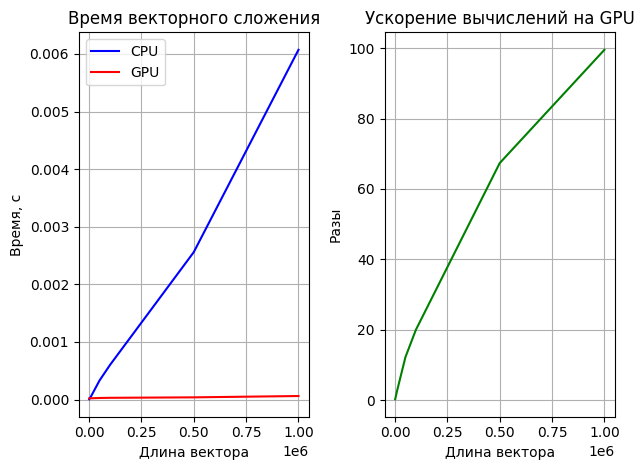

In [53]:
from matplotlib import pyplot as plt
%matplotlib inline

size = [1000, 10000, 50000, 100000, 500000, 1000000]
gpu_time = [0.00002, 0.000022, 0.000027, 0.00003, 0.000038, 0.000061]
cpu_time = [0.000005, 0.000058, 0.00033, 0.00060, 0.002559, 0.006072]

assert len(size) == len(gpu_time)
assert len(size) == len(cpu_time)

acceleration = [cpu / gpu for cpu, gpu in zip(cpu_time, gpu_time)]

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(size, cpu_time, label='CPU', color='b')
axes[0].plot(size, gpu_time, label='GPU', color='r')
axes[0].grid(True)
axes[0].legend()
axes[0].set_xlabel("Длина вектора")
axes[0].set_ylabel("Время, с")
axes[0].set_title("Время векторного сложения")

axes[1].plot(size, acceleration, color='g')
axes[1].grid(True)
axes[1].set_xlabel("Длина вектора")
axes[1].set_ylabel("Разы")
axes[1].set_title("Ускорение вычислений на GPU")

plt.tight_layout()
plt.show()